<div style="color:black;background-color:#F6E6E2"-">
    
# **Part A - Rank the Players**

Who is the best player in the world according to your analysis?

Use data from FIFA 19. Predict the Overall (OVR ) skill Statistic for players in the FIFA 20 Edition. Train on all players from FIFA 19

Graphically represent the Overall data for the players in test set (see below)



**Instructions :**

Sofifa Id, URL, Name, Potential, Real face, URL variables cannot be used during the prediction or learning. 

In case of a change in playing position, alter FIFA 20 position to match FIFA 19 Position 

The final score will be assigned using MSE. 

Test Set: Players from the following Clubs 
<ul>
    
  - FC Barcelona
    
  - FC Bayern München

  - Real Madrid 

  - Paris Saint-Germain

  - Juventus

  - Manchester City

  - Liverpool FC 
</ul>

In [1]:
#Libraries
%matplotlib inline
import math
import numpy as np
import pandas as pd
import seaborn as sns
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.linear_model import Lasso, Ridge
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
import tensorflow as tf
from sklearn.impute import SimpleImputer, KNNImputer

from sklearn.neighbors import KNeighborsClassifier
import seaborn as sns

import warnings

warnings.filterwarnings("ignore")

In [2]:
#importing datasets
fifa_19 = pd.read_csv('https://raw.githubusercontent.com/Saraman04/fifa20/main/data/players_19.csv')
fifa_20 = pd.read_csv("https://raw.githubusercontent.com/Saraman04/fifa20/main/data/players_20.csv")

We need to predict only on these clubs 

FC Barcelona

FC Bayern München

Real Madrid

Paris Saint-Germain

Juventus

Manchester City

Liverpool FC

In [3]:
required_clubs = {'FC Barcelona', 'FC Bayern München', 'Real Madrid', 'Paris Saint-Germain', 'Juventus', 'Manchester City', 'Liverpool FC'}

In [4]:
#selecting only required_clubs
fifa_20 = fifa_20.loc[fifa_20['club'].isin(required_clubs)]


In [5]:
fifa_20['club'].unique()
fifa_20.shape

(188, 104)

In [6]:
#splitting into train and test
X_train_all = fifa_19.drop('overall', axis=1)
X_test_all = fifa_20.drop('overall', axis=1)
y_train = fifa_19.overall
y_test = fifa_20.overall

In [7]:
#using sofifa id as "index"
X_train_all.set_index("sofifa_id", inplace=True)
X_test_all.set_index("sofifa_id", inplace=True)
y_train.index = X_train_all.index
y_test.index = X_test_all.index

## **Data Cleaning**

In [8]:
#function that converts data into float/int otherwise returns as it is
def evaluate_type(x):
    try:
        return eval(x)
    except:
        return x


#function for handling missing values, categorical columns   
def data_processing(x_train, x_test):
    train = x_train.copy()
    test = x_test.copy()
    
    #We are selecting the columns which contributes to calculating overall 
    fill_null = ['release_clause_eur', 'team_jersey_number', 'contract_valid_until', 'pace', 'shooting', 'passing', 'dribbling', 'defending', 'physic', 'ls', 'st', 'rs', 'lw', 'lf', 'cf',
       'rf', 'rw', 'lam', 'cam', 'ram', 'lm', 'lcm', 'cm', 'rcm', 'rm', 'lwb',
       'ldm', 'cdm', 'rdm', 'rwb', 'lb', 'lcb', 'cb', 'rcb', 'rb','attacking_crossing',
       'attacking_finishing', 'attacking_heading_accuracy',
       'attacking_short_passing', 'attacking_volleys', 'skill_dribbling',
       'skill_curve', 'skill_fk_accuracy', 'skill_long_passing',
       'skill_ball_control', 'movement_acceleration', 'movement_sprint_speed',
       'movement_agility', 'movement_reactions', 'movement_balance',
       'power_shot_power', 'power_jumping', 'power_stamina', 'power_strength',
       'power_long_shots', 'mentality_aggression', 'mentality_interceptions',
       'mentality_positioning', 'mentality_vision', 'mentality_penalties',
       'mentality_composure', 'defending_marking', 'defending_standing_tackle',
       'defending_sliding_tackle', 'goalkeeping_diving',
       'goalkeeping_handling', 'goalkeeping_kicking',
       'goalkeeping_positioning', 'goalkeeping_reflexes']
    
    #Dropping Columns with redundant values
    drop = ['player_url','short_name','long_name','potential','joined','real_face','player_tags', 'loaned_from', "gk_diving", 'gk_handling', 'gk_kicking', 'gk_reflexes', 'gk_speed', 'gk_positioning', 'player_traits', 'nation_position', 'nation_jersey_number', 'dob']
    train.drop(drop, axis=1, inplace=True)
    test.drop(drop, axis=1, inplace=True)
    
    #Replacing null values with median of the column
    for col in fill_null: 
        if train[col].dtype not in [ "int64", "float64"]:
            train[col] = pd.Series(map(evaluate_type, train[col]))
            test[col] = pd.Series(map(evaluate_type, test[col])) 
        #imputing values with median    
        imputer = SimpleImputer(strategy="median")
        train[col] = imputer.fit_transform(train[[col]])
        test[col] = imputer.transform(test[[col]])
            
    
    #We will take only one player position(first) and drop others

    player_position_train = []
    for i in x_train.player_positions.astype(str):
        player_position_train.append(i.split(",")[0])
    train.player_positions = player_position_train
    player_position_test = []
    for i in x_test.player_positions.astype(str):
        player_position_test.append(i.split(",")[0])
    test.player_positions = player_position_test
    
    
    #Getting all categorical columns from train data

    cat_cols = [col for col in train.columns if train[col].dtype not in ["int64", "float64"]]  

    #Replacing with most frequent values

    imputer = SimpleImputer(strategy="most_frequent")
    train_cat = imputer.fit_transform(train[cat_cols])
    test_cat = imputer.transform(test[cat_cols])
    
    #OneHotEncoding categorical columns
    OneHotEncode = OneHotEncoder(handle_unknown='ignore', sparse=False)
    train.drop(cat_cols, axis=1, inplace=True)
    train_cat = pd.DataFrame(OneHotEncode.fit_transform(train_cat))
    train_cat.index = x_train.index
    train = train.join(train_cat)

    test_cat = pd.DataFrame(OneHotEncode.transform(test_cat))
    test_cat.index = x_test.index
    test.drop(cat_cols, axis=1, inplace=True)
    test = test.join(test_cat)


    return train, test


In [9]:
X_train, X_test = data_processing(X_train_all, X_test_all)

## **Modelling**

In [10]:
#After trying with linear,ridge and lasso, we decided to use lasso for slightly better perfomance.
#Dataset is too big to fit PolynomialFeatures,hence could not try that with collab,kaggle or ed.
#Using Lasso regression and came up with most appropriate alpha value by trial and error 

model = Lasso(1e-4)
model.fit(X_train, y_train)
fifa_20_pred =pd.Series(model.predict(X_test))
print("Train MSE: %.3f" %(mean_squared_error(model.predict(X_train), y_train)))
print("Test  MSE: %.3f" %(mean_squared_error(fifa_20_pred, y_test)))

Train MSE: 5.388
Test  MSE: 13.821


Since we train with large data of good,average and poor player, using the same model on selectively good players (since the selected clubs are well performing ones) tends to over-estimate the player overall values. Without clubs we got a MSE of 28+.

Since adding clubs to train data we get MSE of 13+



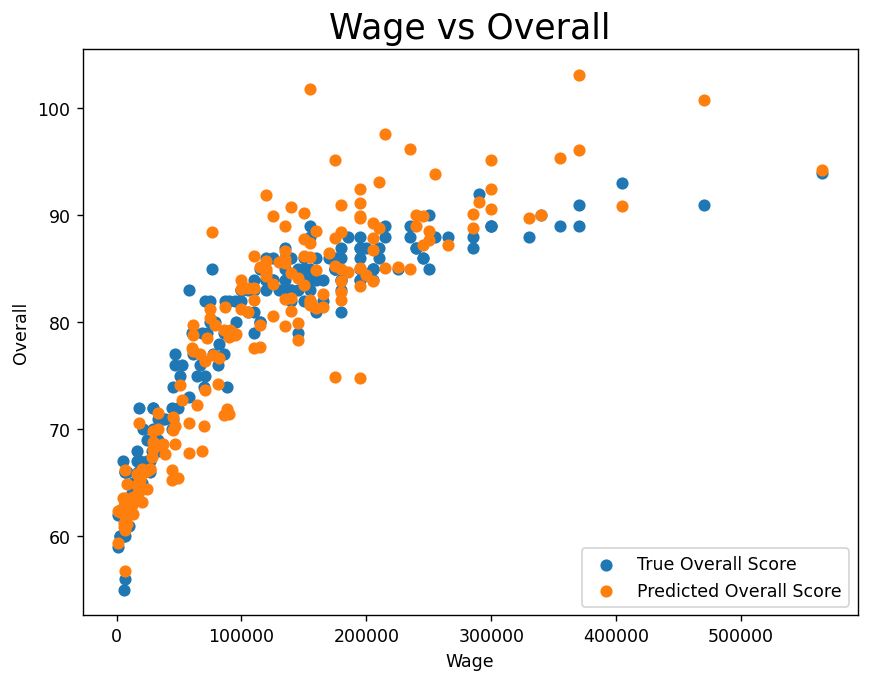

In [11]:
# plot between the wage and overall for both train and test
plt.figure(figsize=(8,6),dpi=125)
plt.scatter(X_test['wage_eur'], y_test, label = 'True Overall Score')
plt.scatter(X_test['wage_eur'], fifa_20_pred, label = 'Predicted Overall Score')
plt.title('Wage vs Overall',fontsize = 20)
plt.xlabel('Wage')
plt.ylabel('Overall')
plt.legend(loc = 'lower right')
plt.show();

In [12]:
#predicting the best player
fifa_20_pred.index = y_test.index
best_player = (X_test_all.loc[fifa_20_pred[fifa_20_pred==fifa_20_pred.max()].index[0]].short_name)
print("The best player in the world according to our model is:", best_player)

The best player in the world according to our model is: K. De Bruyne


Text(0.5, 1.0, 'Club-wise predicted rating for the year 2020')

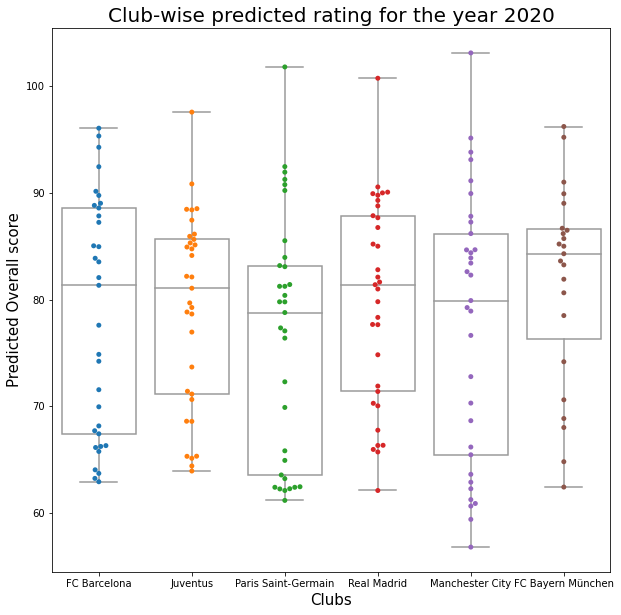

In [13]:
#plot between overall score of players in the 7 mentioned clubs
club_set = ["FC Barcelona","FC Bayern München","Real Madrid" ,"Paris Saint-Germain","Juventus","Manchester City","Liverpool"]
club_set_idx = list(map(lambda x: x in club_set, X_test_all.club))
club_data = [X_test_all[club_set_idx].club.values, fifa_20_pred[club_set_idx].values]

plt.figure(figsize=(10,10))
sns.boxplot(x=club_data[0], y=club_data[1],color = 'white')
sns.swarmplot(x=club_data[0], y=club_data[1])
plt.xlabel("Clubs", fontsize=15)
plt.ylabel("Predicted Overall score", fontsize=15)
plt.title("Club-wise predicted rating for the year 2020", fontsize=20)